In [91]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Additional imports
from sklearn import metrics
from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.cross_validation import train_test_split
import time

In [2]:
# ignore warnings on setting values ona  copy of a DF
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
def load_df(df_file):
    # function to load csv files from data folder into DataFrame
    basepath = 'data/'
    filepath = basepath + df_file
    load_df = pd.DataFrame.from_csv(filepath)
    return load_df

In [59]:
df_ny = load_df('df_ny.csv')
df_sf = load_df('df_sf.csv')
df_la = load_df('df_la.csv')
df_dc = load_df('df_dc.csv')
df_da = load_df('df_da.csv')
df_ch = load_df('df_ch.csv')

In [60]:
def preprocess_data(df, city):
    """Transform data to prepare for model training"""
    
    # add city
    df['City'] = city
    
    # add column for mean price (for baseline model)
    df['Avg_Price'] = df.Price.mean()
    
    # take log of price and add mean log(Price)
    df['log_Price'] = np.log(df.Price)
    df['log_Avg_Price'] = df.log_Price.mean()
    
    # Add log of Review Count
    df['log_Review_Count'] = np.log(df.Review_Count)
    
    # Add log of Capacity
    df['log_Capacity'] = np.log(df.Capacity)
    
    # get rid of -infs as a result of logs on 0
    df['log_Review_Count'] = np.where(df.log_Review_Count<0, 0, df.log_Review_Count)
    
    # map Room Type variable
    df['Room_Type'] = df.Room_Type.map({'Shared room':0,'Private room':1, 'Entire home/apt':2})
    
    # make 'Has_Star_Rating' feature
    df['Has_Star_Rating'] = np.where(df['Star_Rating']>1.0, 1, 0)
    
    cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating','City','Avg_Price',
           'log_Price','log_Avg_Price','log_Review_Count','Has_Star_Rating','log_Capacity']
    
    return df[cols]
    #return df

In [61]:
p_df_ny = preprocess_data(df_ny,'NY')
p_df_sf = preprocess_data(df_sf,'SF')
p_df_la = preprocess_data(df_la,'LA')
p_df_da = preprocess_data(df_da,'DA')
p_df_dc = preprocess_data(df_dc,'DC')
p_df_ch = preprocess_data(df_ch,'CH')

In [62]:
p_df_ny.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,City,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating,log_Capacity
0,1,1,38,1,0,0.0,NY,92.918301,3.637586,4.414075,0.000000,0,0.000000
1,1,1,61,67,1,4.5,NY,92.918301,4.110874,4.414075,4.204693,1,0.000000
2,1,2,58,6,1,5.0,NY,92.918301,4.060443,4.414075,1.791759,1,0.693147
3,1,2,56,36,1,5.0,NY,92.918301,4.025352,4.414075,3.583519,1,0.693147
4,0,2,130,4,2,5.0,NY,92.918301,4.867534,4.414075,1.386294,1,0.693147


### Combine DFs into one

In [42]:
def combine_dfs(df_list):
    data_frame = None
    for df in df_list:
        if data_frame is None:
            data_frame = df
        else:
            data_frame = data_frame.append(df)
    return data_frame

In [63]:
df_list = [p_df_ny, p_df_la, p_df_sf, p_df_da, p_df_dc, p_df_ch]
df_all = combine_dfs(df_list)

In [64]:
df_all.shape

(1836, 13)

In [14]:
def save_df(df, name):
    basepath = 'data/'
    filepath = basepath + name
    df.to_csv(filepath)
    return None

In [65]:
save_df(df_all, 'df_all.csv')

### One-hot encode the City feature

In [66]:
def one_hot_encode(df, feature):
    # One hot encode 'City' feature
    # create dummy variables using get_dummies, then exclude the first column since redundant
    dummies = pd.get_dummies(df[feature], prefix=feature).iloc[:, 1:]

    # concatenate the dummy variable columns onto the original DataFrame
    df = pd.concat([df, dummies], axis=1)
    
    # drop the original feature from the df
    df.drop(feature, axis=1,inplace=True)
    
    return df

In [67]:
df_all = one_hot_encode(df_all,'City')

In [68]:
save_df(df_all, 'df_all.csv')

In [69]:
df_all.head()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,Avg_Price,log_Price,log_Avg_Price,log_Review_Count,Has_Star_Rating,log_Capacity,City_DA,City_DC,City_LA,City_NY,City_SF
0,1,1,38,1,0,0.0,92.918301,3.637586,4.414075,0.000000,0,0.000000,0,0,0,1,0
1,1,1,61,67,1,4.5,92.918301,4.110874,4.414075,4.204693,1,0.000000,0,0,0,1,0
2,1,2,58,6,1,5.0,92.918301,4.060443,4.414075,1.791759,1,0.693147,0,0,0,1,0
3,1,2,56,36,1,5.0,92.918301,4.025352,4.414075,3.583519,1,0.693147,0,0,0,1,0
4,0,2,130,4,2,5.0,92.918301,4.867534,4.414075,1.386294,1,0.693147,0,0,0,1,0


### Look at histograms of features and price

In [70]:
hist_cols = ['Bedrooms','Capacity','Price','Review_Count','Room_Type','Star_Rating',
             'log_Price','log_Review_Count','Has_Star_Rating','log_Capacity']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e57d2d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ee71c90>]], dtype=object)

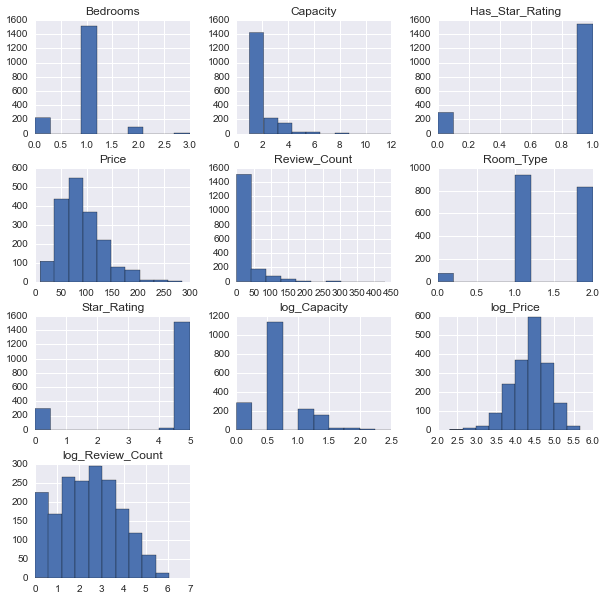

In [71]:
df_all[hist_cols].hist(figsize=(10,10))

### Scatter Matrix (to see correlation between variables)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10f33e410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112204550>]], dtype=object)

/Users/paulsingman/pyth/data-analysis/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


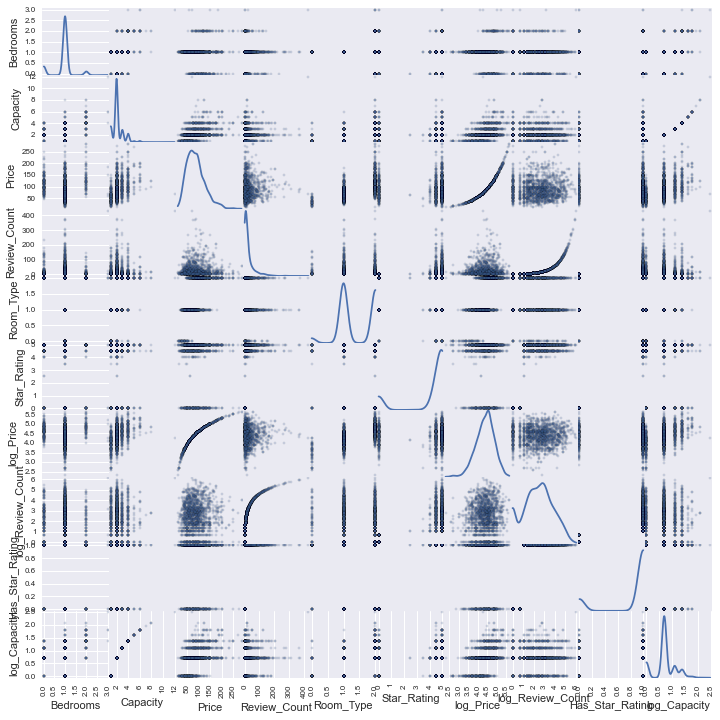

In [72]:
pd.tools.plotting.scatter_matrix(df_all[hist_cols], alpha=0.2, figsize=(12, 12), diagonal='kde')

In [73]:
df_all[hist_cols].corr()

,Bedrooms,Capacity,Price,Review_Count,Room_Type,Star_Rating,log_Price,log_Review_Count,Has_Star_Rating,log_Capacity
Bedrooms,1.000000,0.317923,-0.010372,0.014055,-0.162514,-0.045642,-0.043726,-0.022393,-0.054905,0.218268
Capacity,0.317923,1.000000,0.396855,0.049147,0.443049,-0.007313,0.395427,-0.010641,-0.015300,0.942059
Price,-0.010372,0.396855,1.000000,0.040921,0.618045,0.009269,0.946878,0.022806,-0.003583,0.425167
Review_Count,0.014055,0.049147,0.040921,1.000000,-0.035037,0.273466,0.059506,0.752502,0.271267,0.028931
Room_Type,-0.162514,0.443049,0.618045,-0.035037,1.000000,-0.027815,0.661716,-0.056904,-0.030215,0.487425
Star_Rating,-0.045642,-0.007313,0.009269,0.273466,-0.027815,1.000000,0.011493,0.694623,0.991021,0.003938
log_Price,-0.043726,0.395427,0.946878,0.059506,0.661716,0.011493,1.000000,0.036927,-0.003329,0.443743
log_Review_Count,-0.022393,-0.010641,0.022806,0.752502,-0.056904,0.694623,0.036927,1.000000,0.695094,-0.006794
Has_Star_Rating,-0.054905,-0.015300,-0.003583,0.271267,-0.030215,0.991021,-0.003329,0.695094,1.000000,-0.005661
log_Capacity,0.218268,0.942059,0.425167,0.028931,0.487425,0.003938,0.443743,-0.006794,-0.005661,1.000000


In [76]:
df_all.columns

Index([u'Bedrooms', u'Capacity', u'Price', u'Review_Count', u'Room_Type',
       u'Star_Rating', u'Avg_Price', u'log_Price', u'log_Avg_Price',
       u'log_Review_Count', u'Has_Star_Rating', u'log_Capacity', u'City_DA',
       u'City_DC', u'City_LA', u'City_NY', u'City_SF'],
      dtype='object')

### Fit baseline model (predict the city's average price for every listing)

In [74]:
def fit_baseline(df):
    """Fit baseline prediction model where we predict a city's avg for each listing"""
    predictions = df.log_Avg_Price
    y = df.log_Price
    base_r2 = metrics.r2_score(y, predictions)
    base_RMSE = np.sqrt(metrics.mean_squared_error(y, predictions))
    
    return (base_r2, base_RMSE)

In [75]:
base_r2, base_RMSE = fit_baseline(df_all)
print "Baseline model R-squared: {:.3f}".format(base_r2)
print "Baseline model RMSE: {:.3f}".format(base_RMSE)

Baseline model R-squared: 0.109
Baseline model RMSE: 0.449


### Let's improve upon the baseline and explore different regression models: OLS, Lasso, Ridge, and Elasticnet

In [82]:
regression_vars = ['log_Review_Count','Star_Rating','Has_Star_Rating','Bedrooms','log_Capacity','Room_Type',
                       'City_NY','City_SF','City_DA','City_DC','City_LA','log_Price','Price']

In [83]:
df_regression = df_all[regression_vars]

In [84]:
regression_features = ['log_Review_Count','Star_Rating','Has_Star_Rating','Bedrooms','log_Capacity','Room_Type',
                       'City_NY','City_SF','City_DA','City_DC','City_LA']

In [85]:
X = df_regression[regression_features]
y = df_regression.log_Price

In [86]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [98]:
def train_model(clf, X_train, y_train):
    """Trains the classifier"""
    print "----------------------------"
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
    return clf

In [97]:
def model_predictions(clf, X_train, X_test):
    """Generate predictions from the training and testing data"""
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    return (train_predictions, test_predictions)

In [96]:
def score_model(train_preds, test_preds, train_truth, test_truth):
    """Return the R-squared on the test data, and the RMSE on the train and test data"""
    train_RMSE = np.sqrt(metrics.mean_squared_error(train_truth, train_preds))
    test_RMSE = np.sqrt(metrics.mean_squared_error(test_truth, test_preds))
    
    test_rsquare = metrics.r2_score(test_truth, test_preds)
    
    return (train_RMSE, test_RMSE, test_rsquare)

In [100]:
def regression_model(clf, X_train, X_test, y_train, y_test):
    """This function:
     - trains the model on the training
     - makes predictions on the test set
     - reports the r_squared and RMSE of the model
    """
    clf = train_model(clf, X_train, y_train)
    train_predictions, test_predictions = model_predictions(clf, X_train, X_test)
    train_RMSE, test_RMSE, test_rsquare = score_model(train_predictions, test_predictions, y_train, y_test)
    
    print "RMSE for training set: {}".format(train_RMSE)
    print "RMSE score for test set: {}".format(test_RMSE)
    print "R-Squared for test set: {}".format(test_rsquare)
    
    return clf 

In [92]:
lr_ridge = Ridge()
lr_ols = LinearRegression()
lr_lasso = Lasso()
lr_elasticnet = ElasticNet()

In [101]:
lr_ridge = regression_model(lr_ridge, X_train, X_test, y_train, y_test)

----------------------------
Training Ridge...
Done!
Training time (secs): 0.002
RMSE for training set: 0.299120258281
RMSE score for test set: 0.307587431567
R-Squared for test set: 0.604488303974


In [102]:
lr_ols = regression_model(lr_ols, X_train, X_test, y_train, y_test)

----------------------------
Training LinearRegression...
Done!
Training time (secs): 0.009
RMSE for training set: 0.29884203303
RMSE score for test set: 0.308058619347
R-Squared for test set: 0.60327562101


In [103]:
lr_lasso = regression_model(lr_lasso, X_train, X_test, y_train, y_test)

----------------------------
Training Lasso...
Done!
Training time (secs): 0.005
RMSE for training set: 0.471416661391
RMSE score for test set: 0.489695327447
R-Squared for test set: -0.00247622106389


In [105]:
lr_elasticnet = regression_model(lr_elasticnet, X_train, X_test, y_train, y_test)

----------------------------
Training ElasticNet...
Done!
Training time (secs): 0.002
RMSE for training set: 0.471416661391
RMSE score for test set: 0.489695327447
R-Squared for test set: -0.00247622106389


In [106]:
lr_ridge.coef_

array([ 0.02874955,  0.16446969, -0.84940432,  0.04643475,  0.21339652,
        0.50146716,  0.27987871,  0.49004035,  0.0118296 ,  0.1418469 ,
        0.10702036])

In [107]:
lr_ols.coef_

array([ 0.02940535,  0.21454281, -1.09875995,  0.04592626,  0.2114847 ,
        0.50296163,  0.28899307,  0.49852215,  0.01704595,  0.1502535 ,
        0.114043  ])

In [108]:
lr_lasso.coef_

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.])

In [109]:
lr_elasticnet.coef_

array([ 0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.])